<h1> Task 2, Least Squares Monte Carlo </h1>

Calcualte BOPM on american call and puts
<br>
Use BSM on European put and calls, and compare to the sim's.
<br>
<br>
Use LSMC on american call and put
<br>
<br>
sim 10'000 paths use LSMC on american call
<br>
some stats
<br>
<br>
more stats

In [95]:
# from classes.ex1_code import *
# from classes.ex3_code import *
import pandas as pd

<h2> 2.1

In [96]:
#BOPM call
ex2ai1 = BinPriMod(200,210,0.2,3,3,0.05,'Call','American',)
ex2ai1.set_dividends(cont=True, cont_rate=0.01, TD=None, amount=None)
ex2ai1.storage_values(False)
A_ex2ai1 = ex2ai1.storage_prices(True)[0][0]
#BOPM put
ex2ai2 = BinPriMod(200,210,0.2,3,3,0.05,'Put','American',)
ex2ai2.set_dividends(cont=True, cont_rate=0.01, TD=None, amount=None)
ex2ai2.storage_values(False)
A_ex2ai2 = ex2ai2.storage_prices(True)[0][0]
#BSM call
ex2aii1 = BlaSchMet(200,210,3,0.05,0.01,'Call')
ex2aii1.set_goal(find_price=True,vol=0.2,find_vol=False,price=None)
A_ex2aii1 = ex2aii1 .call_black_scholes()
#BSM put
ex2aii1 = BlaSchMet(200,210,3,0.05,0.01,'Put')
ex2aii1.set_goal(find_price=True,vol=0.2,find_vol=False,price=None)
A_ex2aii2 = ex2aii1.call_black_scholes()

NameError: name 'BinPriMod' is not defined

In [ ]:
pd.DataFrame({'BSM':[A_ex2aii1,A_ex2aii2],
              'BOPM':[A_ex2ai1, A_ex2ai2]}, index=['Call','Put'])

,BSM,BOPM
Call,32.979069,108.852
Put,19.638638,0.000


<h2> 2.2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
foxdf = pd.DataFrame({0:[1,1,1,1 ,1,1,1,1],
                      1:[1.09,1.16,1.22,0.93,1.11,0.76,0.92,0.88],
                      2:[1.08,1.26,1.07,0.97,1.56,0.77,0.84,1.22],
                      3:[1.34,1.54,1.03,0.92,1.52,0.90,1.01,1.34]}).T

In [107]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

class LeaSquMonCar():
    # Uncomment this in order to doublecheck with L&S and their  foxdf
    # def __init__(self, S, K, T, vol, rf,  div_y, option_type, paths, time_steps, df):
    #     self.pathdf =  df

    # Commen out this in order to doublecheck with L&S and their foxdf.
    def __init__(self, S, K, T, vol, rf,  div_y, option_type, paths, time_steps):
        self.pathdf = None

        self.spot = S
        self.strike = K
        self.total_time = T
        self.volatility = vol
        self.risk_free =  rf
        self.dividend_yield = div_y
        self.paths = paths
        self.time_steps = time_steps
        self.h =  self.total_time/self.time_steps
        self.option_type = option_type
        self.payoffdf = None

    def CreatePaths(self,post=None):
        path_list = []
        for path in range(self.paths):
            path_i = [self.spot]
            for steps in range(self.time_steps):
                part1 = (self.risk_free-self.dividend_yield*(1/2)*self.volatility**2)*self.h
                # np.random.seed(4140)
                part2 = np.random.normal(path*steps)
                part3 = self.volatility * np.sqrt(self.h)*part2
                S_t = path_i[-1]*np.e**(part1+part3)
                path_i.append(S_t)
            path_list.append(path_i)
        pathsdf = pd.DataFrame(path_list).T
        self.pathdf = pathsdf
        if post == True:
            return  pathsdf
        
    def regress(self, X, Y):
        Xsq = X**2
        df = pd.DataFrame({'id':np.arange(self.paths),
                        'Y':Y,
                        'X':X,
                        'Xsq':Xsq})
        if self.option_type =='Call':
            df=df[df['X']>self.strike]
        elif self.option_type == 'Put':
            df=df[df['X']<self.strike]
        else:  
            None
            
        train = sm.add_constant(df[['X','Xsq']])
        model = sm.OLS(df['Y'],train).fit()
        cond_exp = list(model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq'])
        if self.option_type == 'Call':
            boolean = pd.Series([(cond_exp[i]>(X[i]-self.strike)) for i in range(len(train))])
            b = pd.Series(np.where(boolean==True, df['Y'],0), index=df.index)
            b1 = pd.Series(np.where(boolean==False,1,0), index=df.index)
        if self.option_type == 'Put':
            boolean = pd.Series([cond_exp[i]>(self.strike-X[i]) for i in range(len(train))])
            b = pd.Series(np.where(boolean==True, Y,0), index=df.index)        
            b1 = pd.Series(np.where(boolean==False,1,0), index=df.index)
        return [b,b1]
        
    def LeastSquares(self,post=None):
        iddf = self.pathdf.T
        iddf['id'] = np.arange(self.paths)
        Payoff_df = iddf
        disc_r = np.e**((-self.risk_free+self.dividend_yield)*self.h)


        for i in range(0,self.time_steps-1,1):
            data_retY = iddf[self.time_steps-i]
            data_retX = iddf[self.time_steps-(i+1)]
            
            if self.option_type == 'Call':
                if i==0:
                    Y =np.where(data_retY-self.strike>0,data_retY-self.strike,0)*disc_r
                else:
                    Y = Payoff_df[self.time_steps-i]*disc_r
                X = np.where(data_retX-self.strike>0,data_retX,0)
            ################
            if self.option_type == 'Put':
                if i == 0:
                    Y =np.where(self.strike-data_retY>0,self.strike-data_retY,0)*disc_r
                else:
                    Y = Payoff_df[self.time_steps-i]*disc_r
                X = np.where(self.strike-data_retX>0,data_retX,0)
            ################
            cond_exp  = self.regress(X,Y)
            zeros = pd.Series(np.zeros(self.paths))
            zeros.loc[cond_exp[0].index] =  cond_exp[0]/disc_r
            Payoff_df[self.time_steps-i] = np.where(zeros>Y,zeros,0)
            ###################
            zeros = pd.Series(np.zeros(self.paths))
            zeros.loc[cond_exp[1].index] =  cond_exp[1]
            if self.option_type == 'Call':
                rest = np.where(X-self.strike != self.strike, X-self.strike,0)
            else:
                rest = np.where(self.strike-X != self.strike, self.strike-X,0)
            Payoff_df[self.time_steps-(i+1)] = np.where(zeros==1,rest,0)
        ###############################
        for idx in range(Payoff_df.shape[0]):
            row = Payoff_df.iloc[idx,1:]
            reset = 0
            for val in range(1,Payoff_df.shape[1]-1):
                if reset == 0:
                    if row[val] > 0:
                        reset += 1
                else:
                    row[val] = 0
            Payoff_df.iloc[idx,1:] = row
        self.payoffdf = Payoff_df
        if post==True:
            return Payoff_df
    
    def PlotEarlyExercise(self):
        # fig, ax = plt.subplots()
        xes = []
        yes = []
        for i in range(0,len(self.payoffdf),1):
            x = np.where(self.payoffdf.iloc[i,1:-1]>0)
            y = sum(self.payoffdf.iloc[i,1:-1])
            if len(x[0]) != 0:
                # if self.option_type == 'Call':
                    # ax.scatter(x[0][0]+1, self.strike+y, color='red', alpha=.3)
                # else:
                    # ax.scatter(x[0][0]+1, self.strike-y, color='red', alpha=.3)
                # ax.plot(self.pathdf[i],color='grey',alpha=0.3)
                xes.append(x[0][0])
                yes.append(y)
        return [xes,yes]
        


<h2> Testing phase

In [ ]:
# foxdf.T

In [ ]:
lsmc = LeaSquMonCar(1, 1.1, 1, 0.0, 0.06, 0.00, 'Put', 8, 3, foxdf)
lsmc.LeastSquares(post=True)
coords = lsmc.PlotEarlyExercise()


C:\Users\Jakob\AppData\Local\Temp\ipykernel_10192\735680202.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond_exp = list(model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq'])
C:\Users\Jakob\AppData\Local\Temp\ipykernel_10192\735680202.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond_exp = list(model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq'])


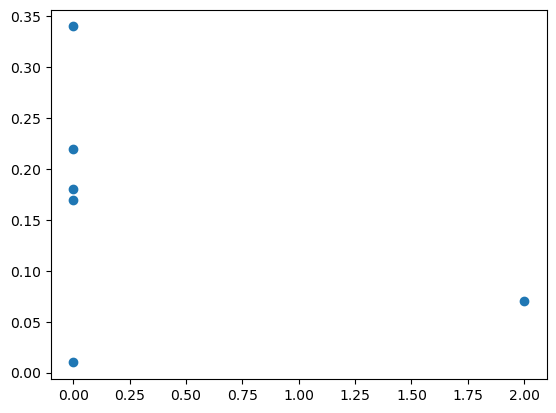

In [ ]:
plt.scatter(coords[0],coords[1])

In [113]:
n_exercises = len(coords[0])
total_npv = []
for i in range(1,len(coords[0]),1):
    # print(coords[0][i]+1)
    pv_sel = coords[1][i]*(np.e**(-0.06))**(coords[0][i]+1)
    total_npv.append(pv_sel)
value = sum(total_npv)/8
print('Call value using LSMC:', round(value,4))

Call value using LSMC: 27.2344


<h2> Testing phase end

In [106]:
np.random.seed(42)
np.random.normal(0,1)

0.4967141530112327

In [93]:
lsmc = LeaSquMonCar(200,210,1,0.2,0.05,0.01,'Call',10,4)
lsmc.CreatePaths(post=True)
lsmc.LeastSquares()
coords = lsmc.PlotEarlyExercise()

# n_exercises = len(coords[0])
# total_npv = []
# for i in range(1,len(coords[0]),1):
#     # print(coords[0][i]+1)
#     pv_sel = coords[1][i]*(np.e**(-0.06))**(coords[0][i]+1)
#     total_npv.append(pv_sel)
# value = sum(total_npv)/8
# print('Call value using LSMC:', round(value,4))

C:\Users\Jakob\AppData\Local\Temp\ipykernel_10192\2787357846.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond_exp = list(model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq'])
C:\Users\Jakob\AppData\Local\Temp\ipykernel_10192\2787357846.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond_exp = list(model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq'])
C:\Users\Jakob\AppData\Local\Temp\ipykernel_10192\2787357846.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

In [233]:
# a = [2,3,4]
# b = [3,3,3]
# c = pd.Series([a[i]>b[i] for i in range(3)])
# np.where(c==True, max((a-2),0),0)

In [232]:
# y  = [0.02, 0, 0.03, 0.13, 0, 0.33, 0.26, 0]
# z = [0.046, 0, 0.052, 0, 0.1, 0.17, 0,15,0]
# np.where(z>y,1,0)

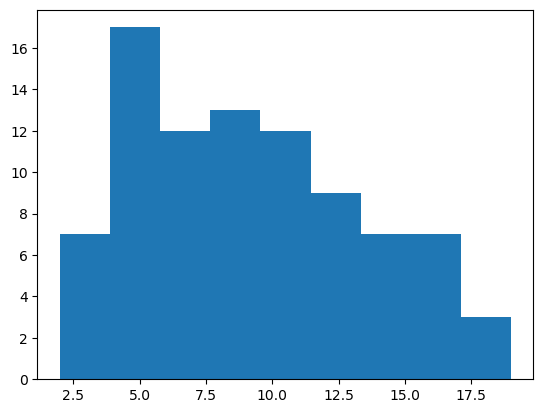

In [16]:
bravo = LeaSquMonCar(200,210,3,0.06,0.05,0.03,'Call',100,20)
bravo.CreatePaths(post=False)
bravo.LeastSquares(post=False)
coords = bravo.PlotEarlyExercise()
plt.hist(coords[0], bins=9)
plt.show()

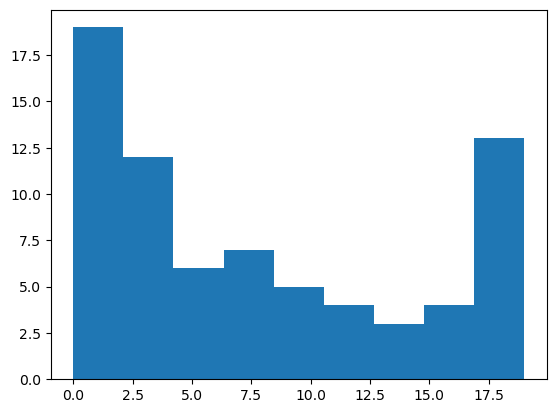

In [17]:
bravo = LeaSquMonCar(200,210,3,0.2,0.05,0.03,'Call',100,20)
bravo.CreatePaths(post=False)
bravo.LeastSquares(post=False)
coords = bravo.PlotEarlyExercise()
plt.hist(coords[0], bins=9)
plt.show()

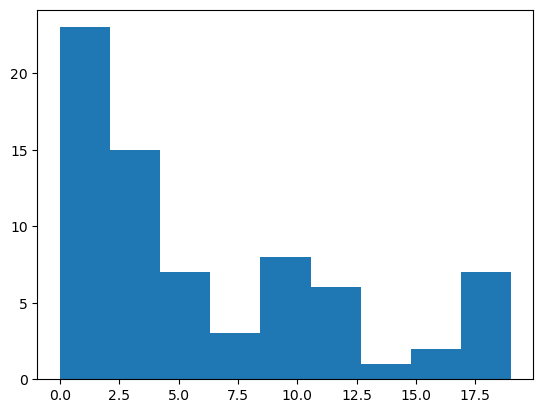

In [18]:
bravo = LeaSquMonCar(200,210,3,0.5,0.05,0.03,'Call',100,20)
bravo.CreatePaths(post=False)
bravo.LeastSquares(post=False)
coords = bravo.PlotEarlyExercise()
plt.hist(coords[0], bins=9)
plt.show()

<AxesSubplot:>

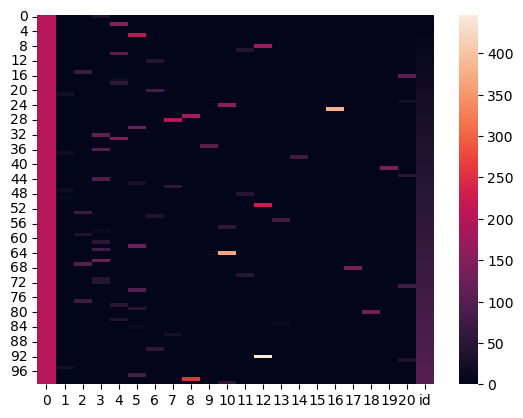

In [20]:
sns.heatmap(bravo.LeastSquares(post=True))

In [142]:
# cdf.T

In [143]:
# df

In [144]:
for idx in range(df.shape[0]):
    row = df.iloc[idx,1:]
    reset = 0
    for val in range(1,df.shape[1]-1):
        if reset == 0:
            if row[val] > 0:
                reset += 1
        else:
            row[val] = 0
    df.iloc[idx,1:] = row
        

In [145]:
# cdf.T

In [146]:
# df

<AxesSubplot:>

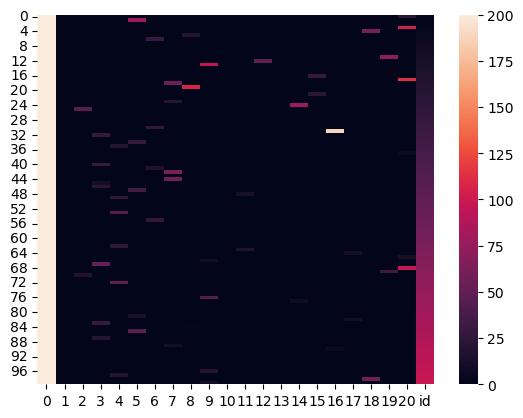

In [147]:
import seaborn as sns
sns.heatmap(df,annot=False)

In [148]:
df.iloc[:,1:].head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,id
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,22.861131,0
1,0.0,0.0,0.0,0.0,79.581233,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,2
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,102.078137,3
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,60.565186,0.0,0.000000,4


In [135]:
cdf

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
1,181.040204,223.461902,214.419203,183.264787,185.788853,185.719033,212.757990,240.163219,227.571566,191.105697,...,215.296280,189.009737,194.252133,195.374288,191.991197,202.177542,195.612111,217.696478,200.872447,201.368832
2,169.183880,221.640673,221.830488,202.345531,202.730746,184.294557,214.716546,238.557507,220.704525,197.228803,...,211.759629,189.143162,199.879895,179.398013,198.048600,211.149072,212.111749,209.778253,216.940247,191.619198
3,151.718703,202.131718,212.390725,221.771575,214.195616,170.683455,201.198978,228.486822,207.604423,203.683866,...,181.068224,206.834057,217.230221,192.378813,194.280742,221.896515,212.327719,206.927633,229.722649,205.545987
4,165.517147,190.505693,222.678834,217.812175,227.411408,189.775163,206.705859,248.790899,198.928106,200.903469,...,189.116880,215.255341,209.465087,203.086751,191.680364,250.994893,207.681021,231.163073,209.468459,187.565362
5,182.798094,181.042144,204.112760,236.693635,219.482644,204.111910,195.861554,250.550849,193.570853,197.716724,...,200.051344,243.756084,222.436587,177.955099,182.266088,224.768052,223.841787,231.081365,209.306024,168.983043
6,194.140106,180.432771,199.309741,239.327390,210.962100,179.791277,189.017846,276.587537,196.156879,205.164245,...,222.391653,231.474213,212.238461,188.717449,173.664198,266.459963,223.709330,248.489299,213.851676,148.867280
7,204.013018,179.822971,181.586668,235.427322,222.141613,175.846348,190.759935,252.013329,193.410128,198.079120,...,223.789418,251.267925,207.931618,194.846172,163.712478,259.650868,225.101375,236.864231,212.490416,141.389337
8,238.423146,169.178416,166.452516,216.625324,230.050414,186.437163,212.473678,250.958190,216.362130,208.013995,...,218.792013,285.756353,213.470068,180.566686,163.811325,287.501283,234.390418,236.569335,210.999441,137.166666
9,263.925688,157.115526,161.154234,219.112760,254.272169,198.144477,204.846457,226.697294,240.076457,182.702403,...,196.778077,358.429704,222.910056,177.632631,170.892030,260.022361,245.184356,221.562181,190.454375,146.429490


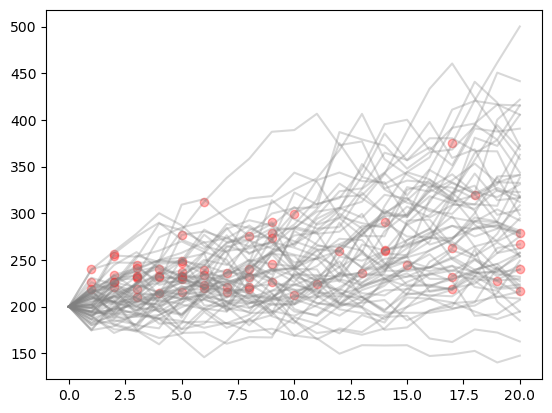

In [172]:
fig, ax = plt.subplots()
wack = []
for i in range(0,len(df),1):
    x = np.where(df.iloc[i,1:-1]>0)
    y = sum(df.iloc[i,1:-1])
    if len(x[0]) != 0:
        ax.scatter(x[0][0]+1,210+y, color='red', alpha=.3)
        ax.plot(cdf[i],color='grey',alpha=0.3)
plt.show()

(array([60., 14.,  0.,  4.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

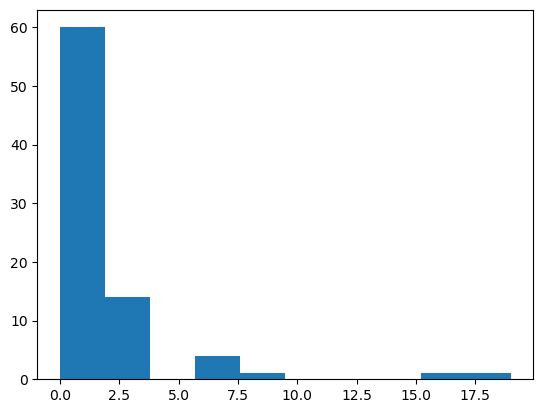

In [100]:
plt.hist(wack)

In [ ]:
Y = np.where(k.T.iloc[:,-1]-210>0, k.T.iloc[:,-1]-210,0)

In [ ]:
def conditional_exp():
    Y = np.where(k.T.iloc[:,-1]-210>0, k.T.iloc[:,-1]-210,0)
    X = np.where(k.T.iloc[:,-2]-210>0, k.T.iloc[:,-2],0)
    Xsq = X**2
    df = pd.DataFrame({'id':np.arange(1000),
                    'Y':Y,
                    'X':X,
                    'Xsq':Xsq})
    df=df[df['X']>210]

    train = sm.add_constant(df[['X','Xsq']])
    model = sm.OLS(df['Y'],train).fit()
    cond_exp = model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq']
    return cond_exp
    # return X
ans = conditional_exp()

In [ ]:
zeros = pd.Series(np.zeros(1000))
zeros.loc[ans.index] =  ans

In [ ]:
k.T[3]-210

0     -52.341324
1      -6.403617
2     -11.211957
3     -20.685782
4      -5.496482
         ...    
995   -48.786262
996    17.520935
997   -63.554106
998   -68.901071
999    10.129414
Name: 3, Length: 1000, dtype: float64

In [ ]:
ans

6       30.150865
7      120.357876
12      14.393518
13      23.897637
17      13.181957
          ...    
992     19.535424
993     33.822335
994     19.123581
996     23.546192
999     16.520661
Length: 488, dtype: float64

In [ ]:
k.T[3]-210-ans

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
995         NaN
996   -6.025256
997         NaN
998         NaN
999   -6.391247
Length: 1000, dtype: float64

In [ ]:
k.T[3]

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
995           NaN
996    203.974744
997           NaN
998           NaN
999    203.608753
Length: 1000, dtype: float64

In [ ]:
np.where(zeros>Y,zeros,0)

array([  0.        ,  31.7224854 ,   0.        ,   0.        ,
         6.45364506,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  15.04480982,
        22.40052697,  56.81678342,   0.        ,   0.        ,
         0.        ,  73.48731904,  81.49917616,   0.        ,
       110.74718314,  37.63742149,  60.07719179,  90.05732025,
         0.        ,   0.        ,   0.        ,   0.        ,
        20.61529588,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        28.37133323,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  43.39264556,
         0.        ,   0.        ,   0.        ,   0.        ,
         1.71033068,   5.8374949 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [ ]:
zeros = pd.Series(np.zeros(1000))
zeros.loc[ans.index] =  ans
zeros

0       0.000000
1      31.722485
2       0.000000
3       0.000000
4       6.453645
         ...    
995    39.919772
996     0.000000
997    35.897040
998     3.164965
999     0.000000
Length: 1000, dtype: float64

In [ ]:
O_df = k.T
O_df[100] = Y
O_df[99] = zeros


In [ ]:
O_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,200.0,202.603035,200.921814,195.561419,200.161973,201.859874,194.413651,191.917996,202.831248,203.614087,...,239.067728,237.377527,228.482698,235.350777,229.912861,228.846315,224.650204,225.392379,21.592862,0.000000
1,200.0,204.148441,204.333357,206.049221,200.394745,202.280965,198.343355,200.326991,206.808617,213.792211,...,167.860382,166.164733,172.239133,169.954093,169.300282,171.605643,173.399792,176.390725,0.000000,0.000000
2,200.0,203.090766,206.071670,205.185886,211.929679,214.684061,213.865712,213.326905,211.984202,213.464511,...,259.949181,271.378948,258.279213,252.303483,257.123448,257.821968,250.764120,259.031106,52.079827,13.486870
3,200.0,202.827370,205.789060,206.124209,210.799670,218.443184,217.926471,217.500560,214.931225,211.781179,...,193.812041,199.222509,201.302225,200.954911,197.655106,196.656235,195.395902,194.712975,0.000000,54.647976
4,200.0,205.267576,205.764354,212.078335,218.705798,227.536180,222.419811,219.624721,211.115918,214.264912,...,251.616581,252.672079,248.423647,256.702264,256.927279,264.479062,260.000148,260.770592,53.589698,59.822230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200.0,205.013094,204.996956,208.154026,209.240503,208.819045,210.497696,204.349254,208.131047,209.742837,...,166.703692,166.434251,159.648187,155.766758,156.403740,157.833697,160.563898,163.966309,0.000000,0.000000
996,200.0,199.876127,203.379556,208.907953,205.410980,212.746878,212.211769,209.980628,209.787861,208.631670,...,258.282086,265.610215,263.676437,268.726587,267.708672,264.137679,263.415628,268.783725,59.785464,66.390685
997,200.0,203.901527,207.469222,209.741453,210.729013,208.435507,209.391385,203.640737,207.448317,217.523046,...,209.490018,210.488882,207.045060,202.340265,202.469154,204.082071,201.743193,198.554241,0.000000,105.891630
998,200.0,201.596099,197.949526,202.588710,199.468586,195.180136,192.957670,191.843118,194.423848,193.542437,...,225.639997,230.669386,225.461800,230.135843,223.860813,221.915432,219.715799,212.838200,0.000000,26.331530


In [ ]:
O_df = k.T
O_df['id'] = np.arange(1000)
# O_df.head(2)

In [ ]:
O_df['id'][ans.index]

2        2
3        3
4        4
8        8
9        9
      ... 
992    992
996    996
997    997
998    998
999    999
Name: id, Length: 526, dtype: int32

In [ ]:
B_df = k.T
B_df['id'] = np.arange(1000)
B_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,id
0,200.0,201.487019,198.623045,197.063033,194.993096,193.772121,198.196304,199.075500,201.547265,205.660915,...,186.756461,185.946797,195.042593,193.156919,194.793968,193.078263,191.584751,199.665066,203.771750,0
1,200.0,198.472394,193.654662,193.515050,188.968069,188.137960,188.293081,184.432329,185.517172,181.732651,...,195.781271,195.393957,188.212440,186.830093,186.186214,184.685334,184.105181,185.800126,191.598807,1


In [ ]:
PO_df = k.T
PO_df['id'] = np.arange(1000)
PO_df[100] = Y
PO_df
# PO_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,id
0,200.0,201.487019,198.623045,197.063033,194.993096,193.772121,198.196304,199.075500,201.547265,205.660915,...,186.756461,185.946797,195.042593,193.156919,194.793968,193.078263,191.584751,199.665066,0.000000,0
1,200.0,198.472394,193.654662,193.515050,188.968069,188.137960,188.293081,184.432329,185.517172,181.732651,...,195.781271,195.393957,188.212440,186.830093,186.186214,184.685334,184.105181,185.800126,0.000000,1
2,200.0,195.355991,198.214845,205.205957,201.452843,199.706172,196.755559,208.044357,202.060416,204.058610,...,220.471237,220.945114,220.012449,222.110266,223.348506,218.659222,227.692081,230.443822,13.486870,2
3,200.0,199.211409,190.899800,190.539165,183.239508,182.476098,186.001869,181.456737,185.296297,189.958635,...,247.353441,249.222050,257.017137,258.679287,258.232885,270.070962,266.614678,265.975862,54.647976,3
4,200.0,206.173959,202.555710,196.362601,200.539165,202.818485,208.928527,209.026552,204.826914,212.574033,...,265.766150,267.934339,265.157308,268.208474,271.905493,274.268429,276.185407,273.619256,59.822230,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200.0,203.167161,202.675174,205.735493,202.830698,210.300437,217.388476,225.267052,228.076912,224.952127,...,204.382326,199.737785,188.573845,188.216738,188.872739,187.706153,190.127600,187.615171,0.000000,995
996,200.0,203.726659,199.086193,204.331981,201.356135,197.970455,197.684542,199.810232,188.386650,193.190796,...,273.071386,267.831998,265.694690,271.435787,280.246603,273.966014,275.952604,272.640562,66.390685,996
997,200.0,203.466606,203.342756,206.483638,207.523415,209.856469,214.184561,215.248997,223.121454,223.558505,...,313.523247,303.059733,296.260571,302.850277,301.308330,301.307183,305.622069,310.358570,105.891630,997
998,200.0,201.450724,201.197975,206.461259,204.619358,203.810990,201.783759,201.289373,200.203999,196.744456,...,222.203480,236.069507,235.713000,238.970646,241.575862,244.766158,235.044813,243.670186,26.331530,998


In [ ]:
# bravo = alfa['id'][df['id']].index 

In [ ]:
# np.where(alfa[100]==bravo)

(-0.01, 0.01)

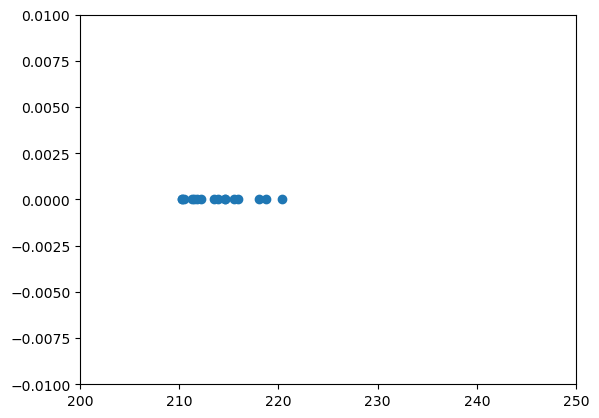

In [ ]:
plt.scatter(X,Y)
plt.xlim(200,250)
plt.ylim(-0.01,0.01)

In [ ]:
np.where(X-210>0,X-210,0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  7.98094129,  9.376824  ,  9.06732104,
        5.49129684, 11.5085016 ,  5.49896954,  6.25112407,  4.50353296,
        7.25104448, 10.62557876, 10.91080428, 11.7917145 , 15.49732306,
       10.95834899, 11.80425633, 10.31582365,  3.86294069,  9.19303897,
        8.94255744, 11.0257323 ,  3.02542172,  0.        ,  0.49454615,
        4.58255114,  1.28232394,  0.        ,  0.        ,  0.        ,
        0.23163886,  0.        ,  0.        ,  0.        ,  0.        ,
        2.13629645,  0.        ,  0.        ,  0.        ,  1.89667773,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  6.83084181,
        5.70083606,  0.        ,  1.65832901,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.11977584,  2.57683397,  5.5808393 ,  1.45993485,  0.39

In [ ]:
cond_exp[8]

0.277873166584889

In [ ]:
# np.where(k[0]-210>0,k[0]-210,0)

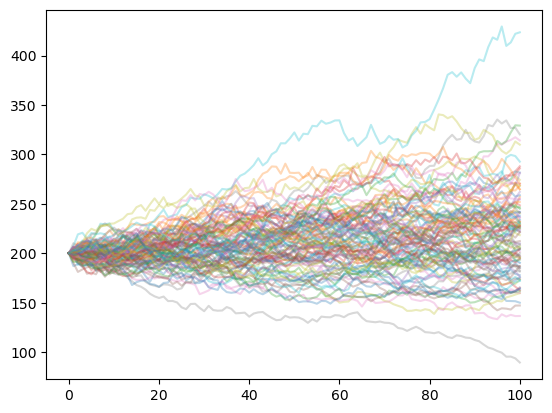

In [ ]:
fig, ax = plt.subplots()
for i in range(0,len(k),1):
    ax.plot(k[i], alpha=0.3)

In [ ]:

# alfa = [50]
# for i in range(0,5,1):
#     part1 =  alfa[-1]
#     part2 = (0.05-0.01*(1/2)*0.3**2)*1
#     Z = np.random.normal(0,1)
#     part3 = 0.3*sqrt(0.1)*Z
#     wack =  part1*np.e**(part2+part3)
#     alfa.append(wack)
